In [332]:
import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler


%matplotlib inline
plt.rcParams["figure.figsize"] = (16,10)
warnings.simplefilter("ignore")

sns.set(style="darkgrid")

In [208]:
train = pd.read_csv('train.csv')

Проверим данные на nan

In [209]:
train.isna().sum().sum()

0

Проверим на дубликаты

In [210]:
train.count().min() == train.shape[0]

True

In [211]:
train.sample(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
879528,id3559937,1,2016-06-30 02:18:38,2016-06-30 02:29:55,1,-73.982513,40.764278,-73.982979,40.738003,N,677
1405874,id2184133,2,2016-03-29 19:40:16,2016-03-30 19:22:51,2,-73.972038,40.759800,-73.981987,40.745899,N,85355
270291,id0891087,1,2016-02-02 19:24:13,2016-02-02 19:32:25,1,-74.000984,40.748051,-73.984238,40.763145,N,492
1006626,id2382131,1,2016-04-08 00:46:27,2016-04-08 01:05:36,1,-73.872826,40.774086,-73.979050,40.762085,N,1149
169529,id3532522,1,2016-05-02 15:32:56,2016-05-02 15:43:03,1,-73.992638,40.730709,-74.001984,40.716839,N,607


Признак dropoff_datetime не применим. Зависимости в id слишком сложно найти, если она есть.

In [212]:
train.drop(columns=['dropoff_datetime', 'id'], inplace=True)

Переведем в удобнйы формат

In [213]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

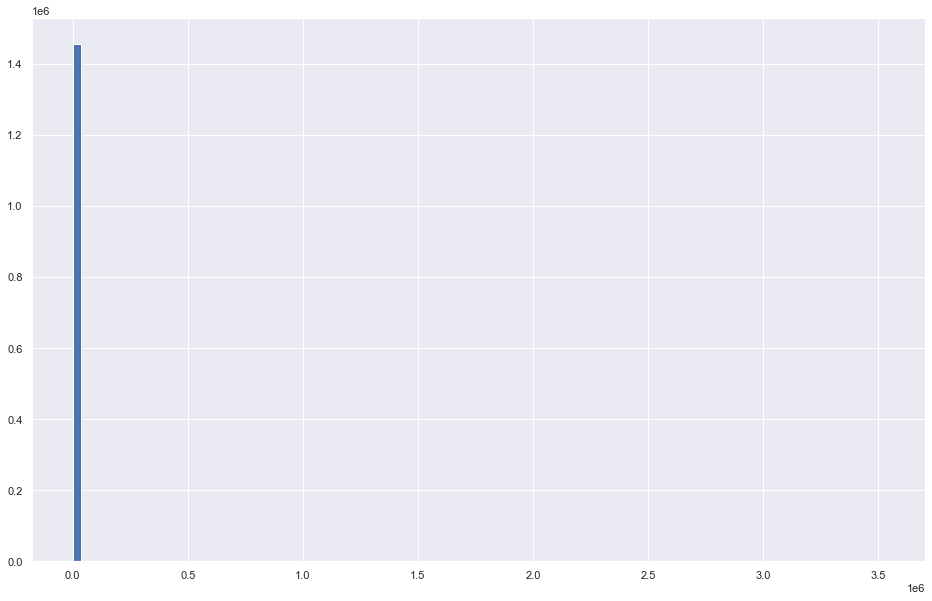

In [214]:
plt.hist(train['trip_duration'], bins = 100)
plt.show()

## Замена

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

Вместо этого сделаем замену $\hat{y}_i = \log{(y_i + 1)}$

Будем решать эквивалентную задачу минимизации $\text{RMSE}$

In [215]:
train['log_trip_duration'] = np.log1p(train['trip_duration'])

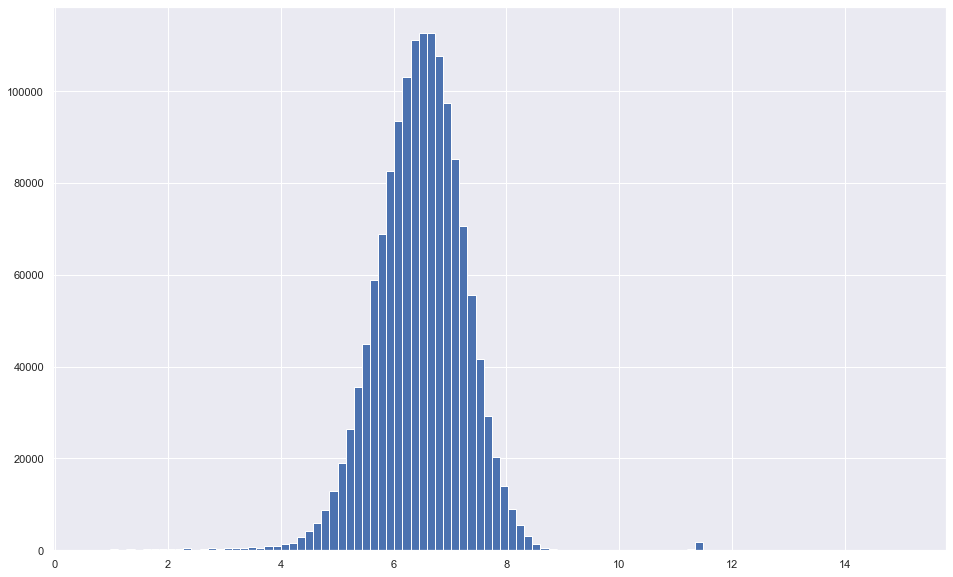

In [216]:
plt.hist(train['log_trip_duration'], bins = 100)
plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [217]:
train.drop('trip_duration', axis = 1, inplace=True)

In [218]:
mean_squared_error(train['log_trip_duration'], [train['log_trip_duration'].mean()]*train.shape[0], squared=False)

0.7957592365411504

## Рассмотрим признак pickup_datetime

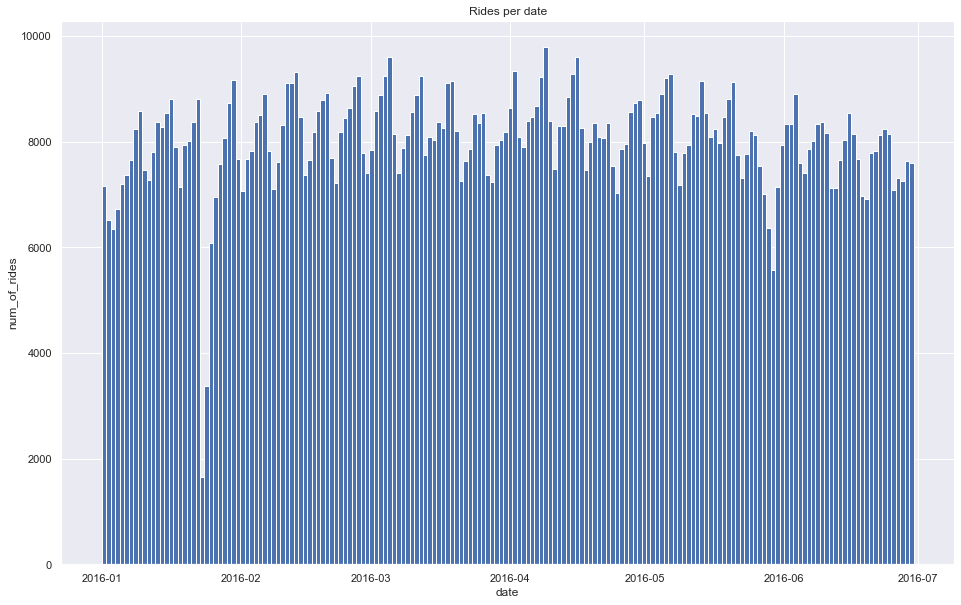

In [219]:
temp = train['pickup_datetime'].map(lambda x: x.date())
plt.hist(temp, bins=len(temp.unique()))
plt.xlabel('date')
plt.ylabel('num_of_rides')
plt.title('Rides per date')
plt.show()

Можно выделить два аномальных периода

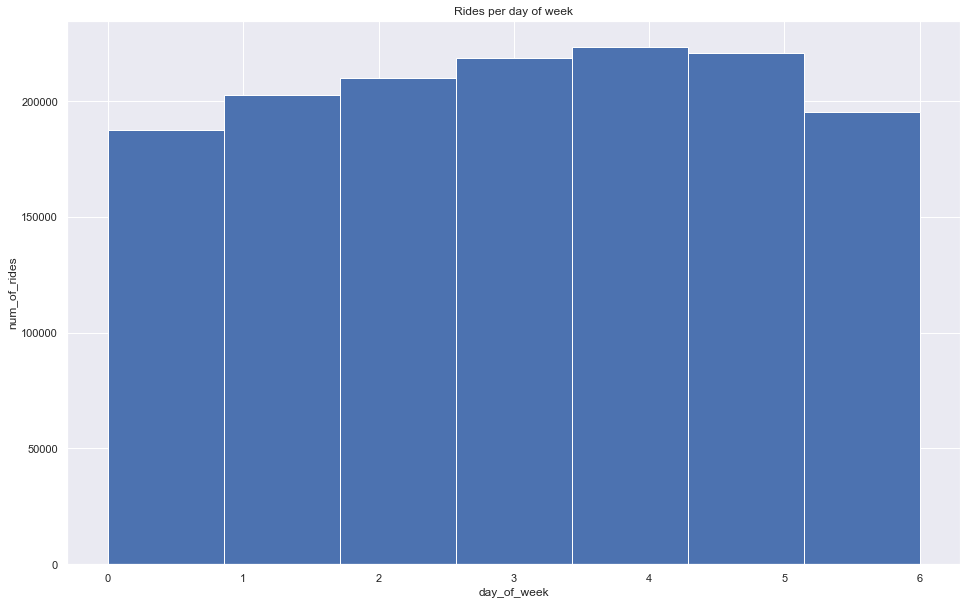

In [220]:
temp = train['pickup_datetime'].map(lambda x: x.day_of_week)
plt.hist(temp, bins=7)
plt.xlabel('day_of_week')
plt.ylabel('num_of_rides')
plt.title('Rides per day of week')
plt.show()

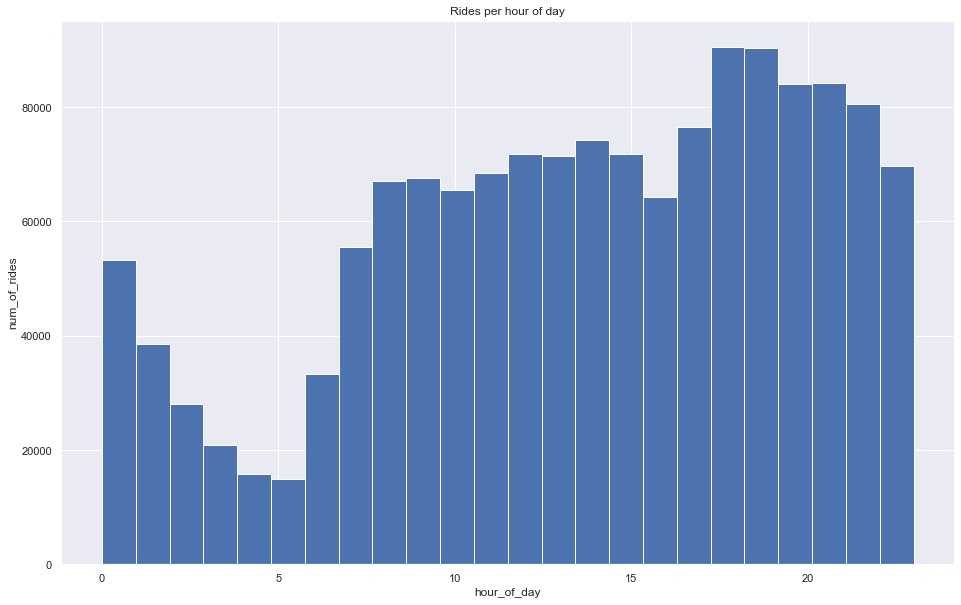

In [221]:
temp = train['pickup_datetime'].map(lambda x: x.hour)
plt.hist(temp, bins=24)
plt.xlabel('hour_of_day')
plt.ylabel('num_of_rides')
plt.title('Rides per hour of day')
plt.show()

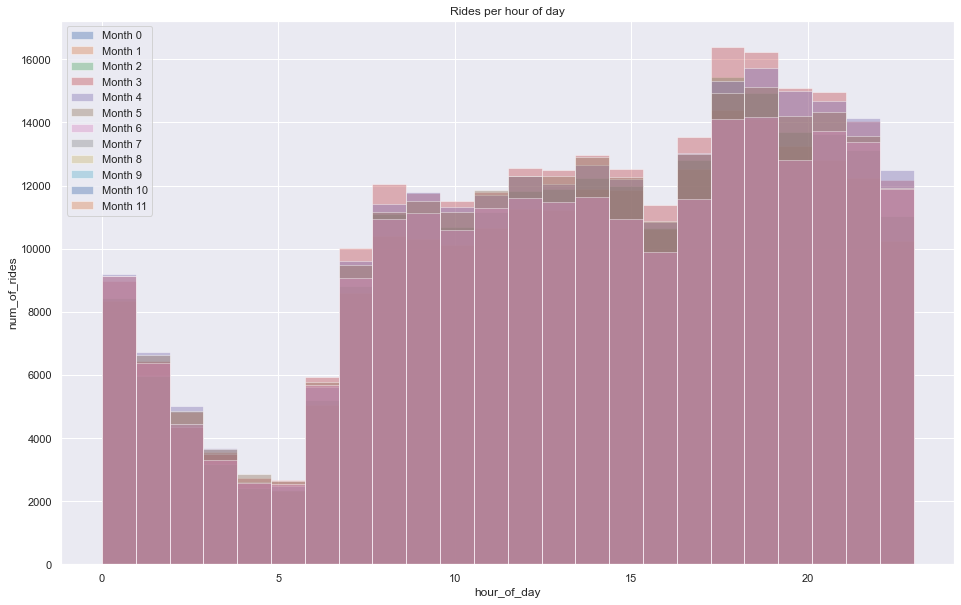

In [222]:
for i in range(12):
    temp = train[train['pickup_datetime'].map(lambda x: x.month) == i]['pickup_datetime'].map(lambda x: x.hour)
    plt.hist(temp, bins=24, label = f'Month {i}', alpha=0.4)
    plt.xlabel('hour_of_day')
    plt.ylabel('num_of_rides')
    plt.title('Rides per hour of day')
plt.legend()
plt.show()

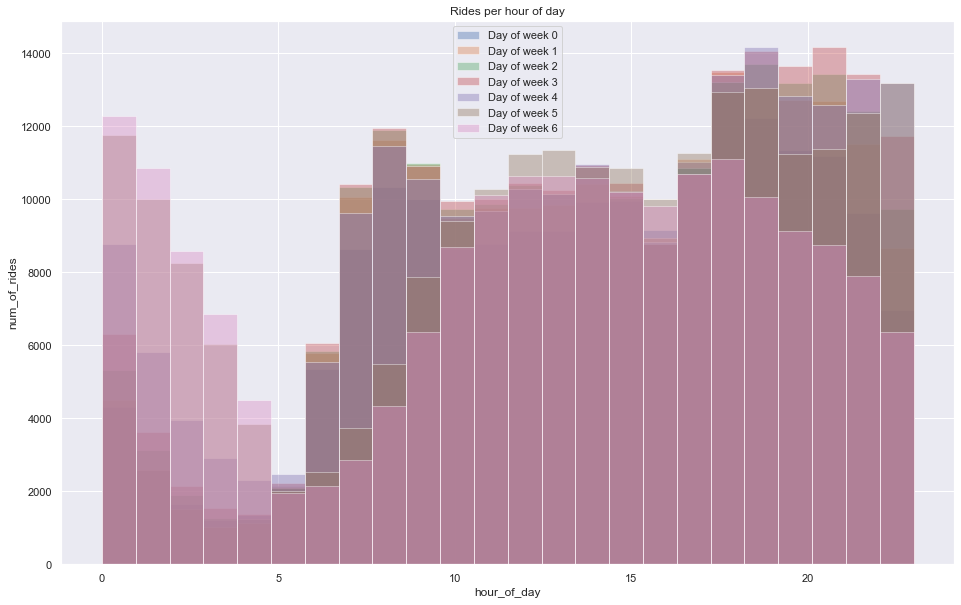

In [223]:
for i in range(7):
    temp = train[train['pickup_datetime'].map(lambda x: x.day_of_week) == i]['pickup_datetime'].map(lambda x: x.hour)
    plt.hist(temp, bins=24, label = f'Day of week {i}', alpha=0.4)
    plt.xlabel('hour_of_day')
    plt.ylabel('num_of_rides')
    plt.title('Rides per hour of day')
plt.legend()
plt.show()

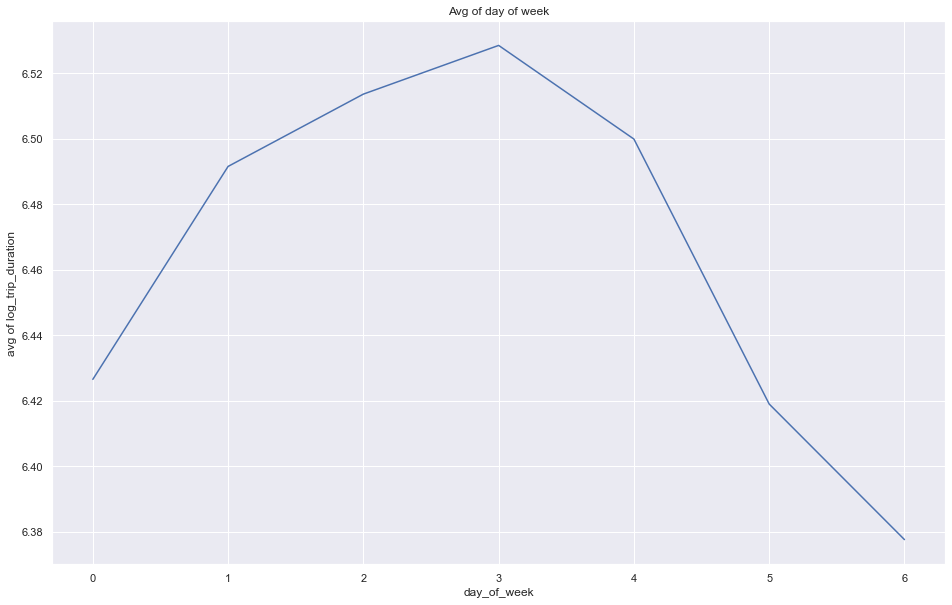

In [224]:
temp = train.groupby(by=lambda x: train.loc[x, 'pickup_datetime'].day_of_week).mean()['log_trip_duration']
plt.plot(temp.keys(), temp)
plt.xlabel('day_of_week')
plt.ylabel('avg of log_trip_duration')
plt.title('Avg of day of week')
plt.show()

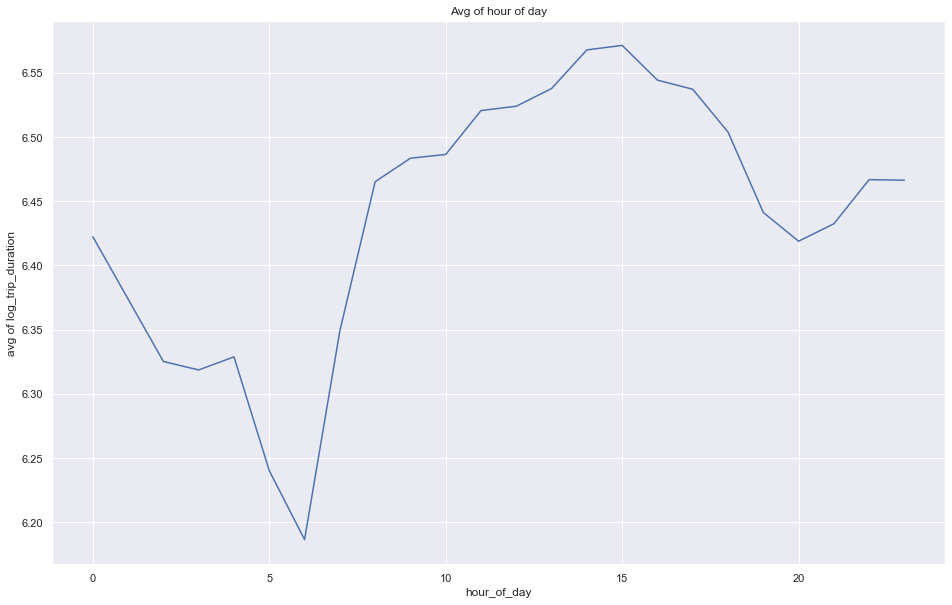

In [225]:
temp = train.groupby(by=lambda x: train.loc[x, 'pickup_datetime'].hour).mean()['log_trip_duration']
plt.plot(temp.keys(), temp)
plt.xlabel('hour_of_day')
plt.ylabel('avg of log_trip_duration')
plt.title('Avg of hour of day')
plt.show()

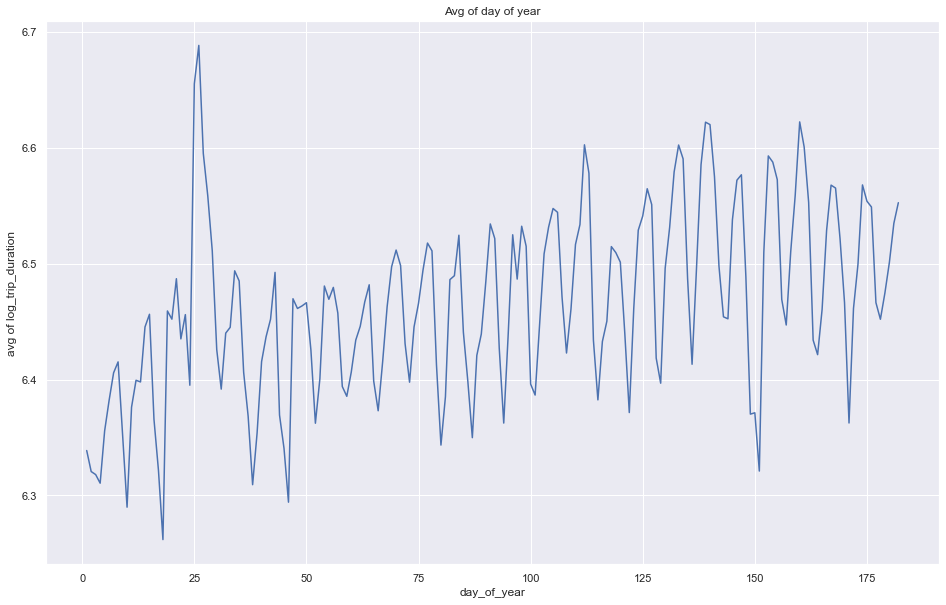

In [226]:
temp = train.groupby(by=lambda x: train.loc[x, 'pickup_datetime'].day_of_year).mean()['log_trip_duration']
plt.plot(temp.keys(), temp)
plt.xlabel('day_of_year')
plt.ylabel('avg of log_trip_duration')
plt.title('Avg of day of year')
plt.show()

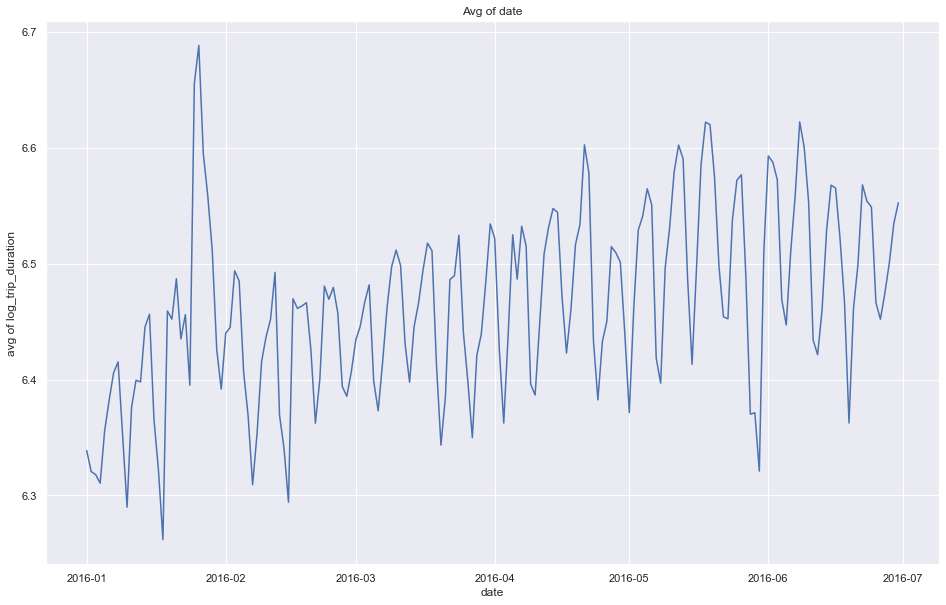

In [227]:
temp = train.groupby(by=lambda x: train.loc[x, 'pickup_datetime'].date()).mean()['log_trip_duration']
plt.plot(temp.keys(), temp)
plt.xlabel('date')
plt.ylabel('avg of log_trip_duration')
plt.title('Avg of date')
plt.show()

Добавим следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [228]:
def abnormal1(x):
    if x.year == 2016 and x.month == 1 and  x.day >= 19 and x.day <= 29:
        return 1
    return 0

In [229]:
def abnormal2(x):
    if x.year == 2016 and x.month == 5 and  x.day >= 25 and x.day <= 30:
        return 1
    return 0

In [230]:
train['day_of_week'] = train['pickup_datetime'].map(lambda x: x.day_of_week)
train['month'] = train['pickup_datetime'].map(lambda x: x.month)
train['hour'] = train['pickup_datetime'].map(lambda x: x.hour)
train['abnormal1'] = train['pickup_datetime'].map(abnormal1)
train['abnormal2'] = train['pickup_datetime'].map(abnormal2)
train['day_of_year'] = train['pickup_datetime'].map(lambda x: x.day_of_year)

In [231]:
train.drop('pickup_datetime', axis=1, inplace=True)

## Рассмотрим координаты


In [232]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    
    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [233]:
show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [234]:
show_circles_on_map(train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

Можно выделить две точки за пределами Мэнхэттана: J.F.K. Int. Airport и LaGuardia Airport

Рассмотрим зависимость $t=s/v => \ln{t} = \ln{s} - \ln{v}$ 

In [235]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [236]:
train['haversine'] = haversine_array(train['pickup_latitude'], train['pickup_longitude'], train['dropoff_latitude'], train['dropoff_longitude'])

In [237]:
train['log_haversine'] = np.log1p(train['haversine'])

In [238]:
train['log_velocity'] = train['log_haversine'] - np.log1p(np.exp(train['log_trip_duration'])-1)

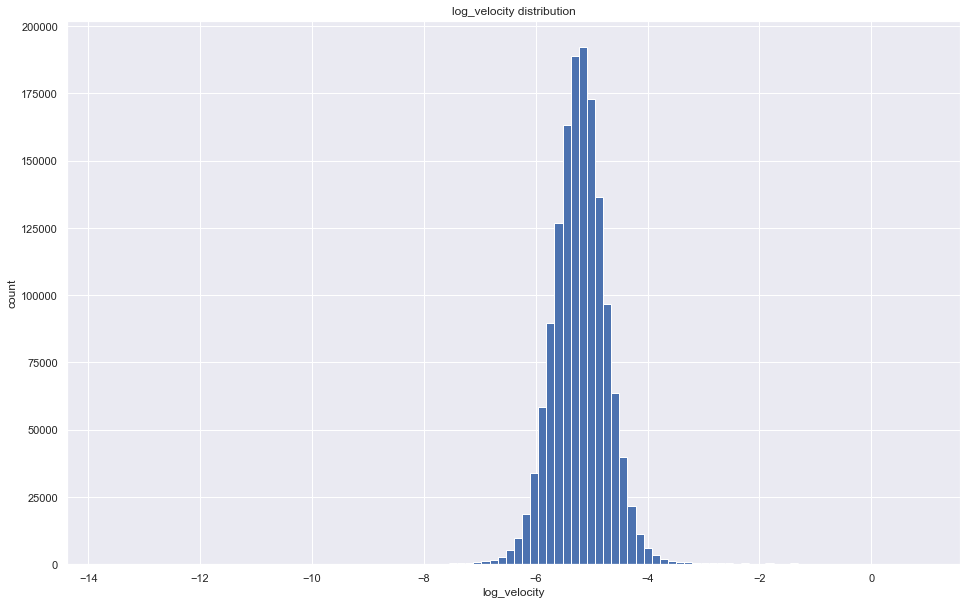

In [239]:
plt.hist(train['log_velocity'], bins=100)
plt.xlabel('log_velocity')
plt.ylabel('count')
plt.title('log_velocity distribution')
plt.show()

In [240]:
velocity = train['log_velocity']
Q1 =  velocity.quantile(0.25)
Q3 = velocity.quantile(0.75)
IQR = Q3 - Q1
velocity = velocity[(velocity >= Q1-1.5*IQR ) & (velocity <= Q3+1.5*IQR)]#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

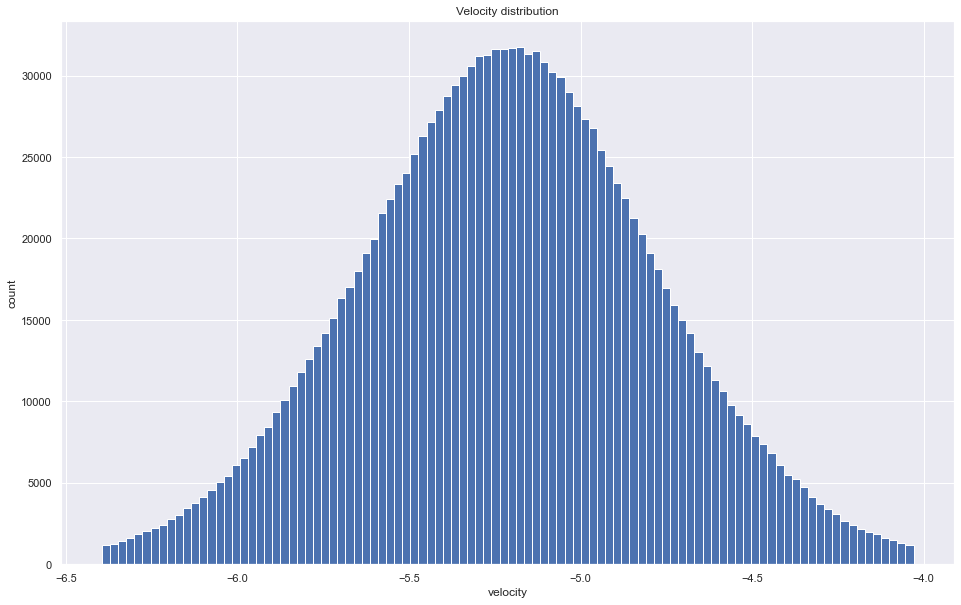

In [241]:
plt.hist(velocity, bins=100)
plt.xlabel('velocity')
plt.ylabel('count')
plt.title('Velocity distribution')
plt.show()

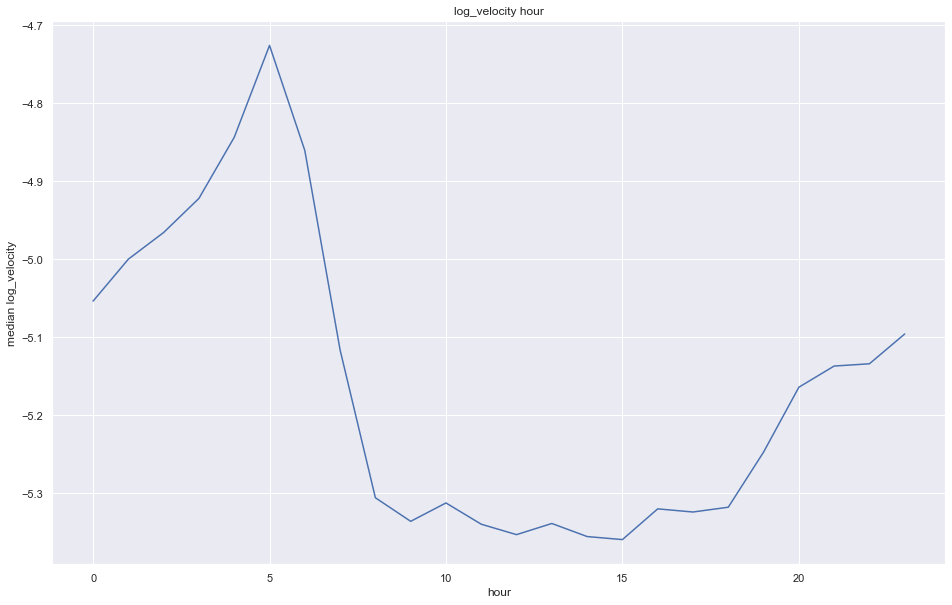

In [242]:
temp = train.groupby('hour').median()['log_velocity']
plt.plot(temp.keys(), temp)
plt.xlabel('hour')
plt.ylabel('median log_velocity')
plt.title('log_velocity hour')
plt.show()

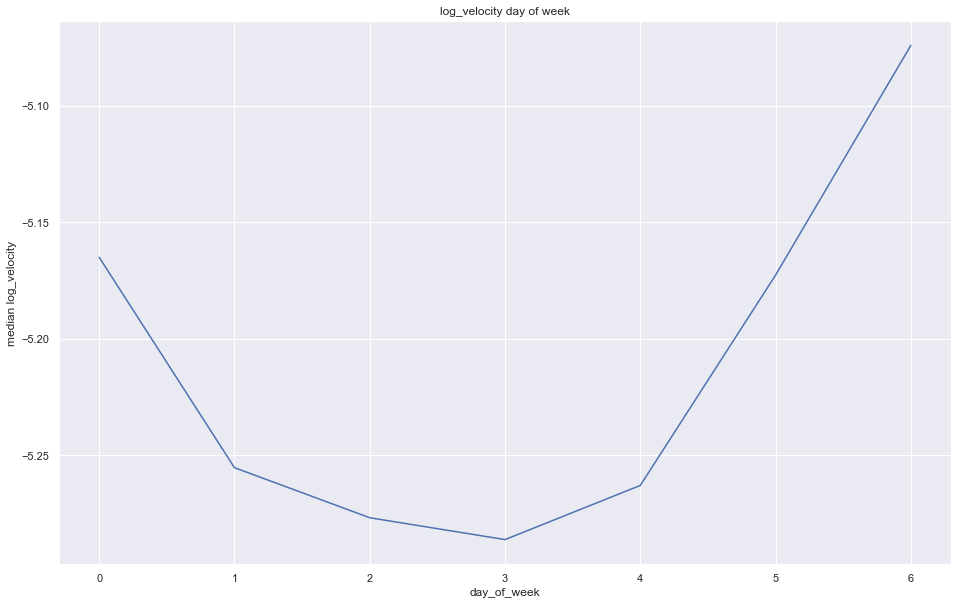

In [243]:
temp = train.groupby('day_of_week').median()['log_velocity']
plt.plot(temp.keys(), temp)
plt.xlabel('day_of_week')
plt.ylabel('median log_velocity')
plt.title('log_velocity day of week')
plt.show()

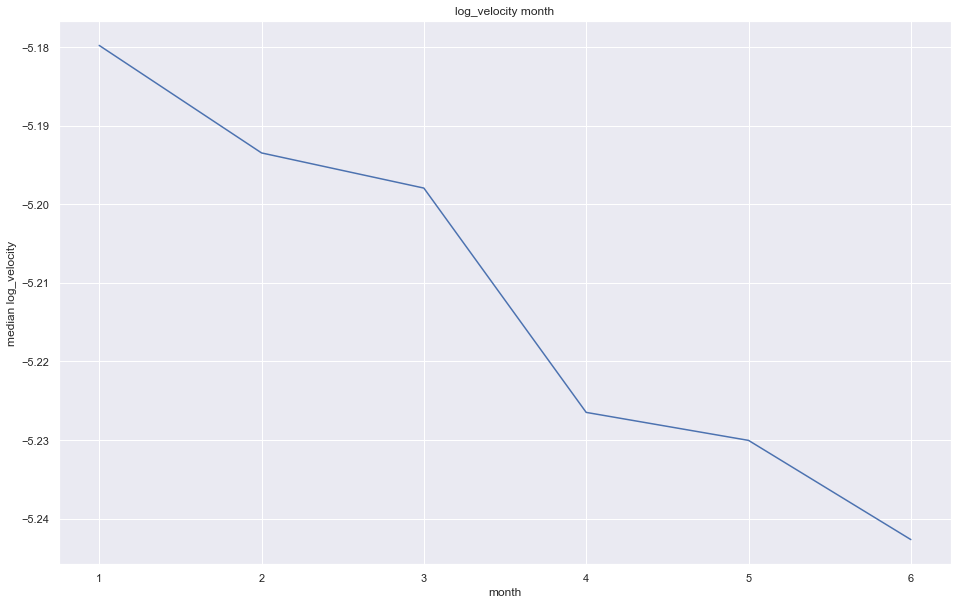

In [244]:
temp = train.groupby('month').median()['log_velocity']
plt.plot(temp.keys(), temp)
plt.xlabel('month')
plt.ylabel('median log_velocity')
plt.title('log_velocity month')
plt.show()

Добавим следующие признаки:
1. Выходной
2. Часть дня

In [245]:
def work_day(x):
    if 0 <= x <= 4:
        return 1
    return 0

def part_of_day(x):
    if (0 <= x <= 5) or x >= 18:
        return 0
    if 5 <= x <= 8:
        return 1
    return 2

In [246]:
train['part_of_day'] = train['hour'].map(part_of_day)
train['part_of_week'] = train['day_of_week'].map(work_day)

In [247]:
train.drop('log_velocity', axis=1, inplace=True)
train.drop(['day_of_week', 'hour'], axis=1, inplace=True)

Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена

In [248]:
r0 = np.sqrt((40.76657-40.77255)**2+(-73.87208+73.86343)**2)
lat0 = 40.77255
lon0 = -73.87208 

In [249]:
r1 = np.sqrt((40.64568-40.64878)**2+(-73.78561+73.77960)**2)
lat1 = 40.64568
lon1 = -73.78561

In [250]:
def airport(lat_column, lon_colmn):
    x1 = ((lat_column-lat0)**2+(lon_colmn-lon0)**2 <= r1**2).astype('int64')
    x2 = 2*((lat_column-lat1)**2+(lon_colmn-lon1)**2 <= r1**2).astype('int64')
    return x1+x2

In [251]:
train['pickup_airport'] = airport(train['pickup_latitude'], train['pickup_longitude'])
train['dropoff_airport'] = airport(train['dropoff_latitude'], train['dropoff_longitude'])

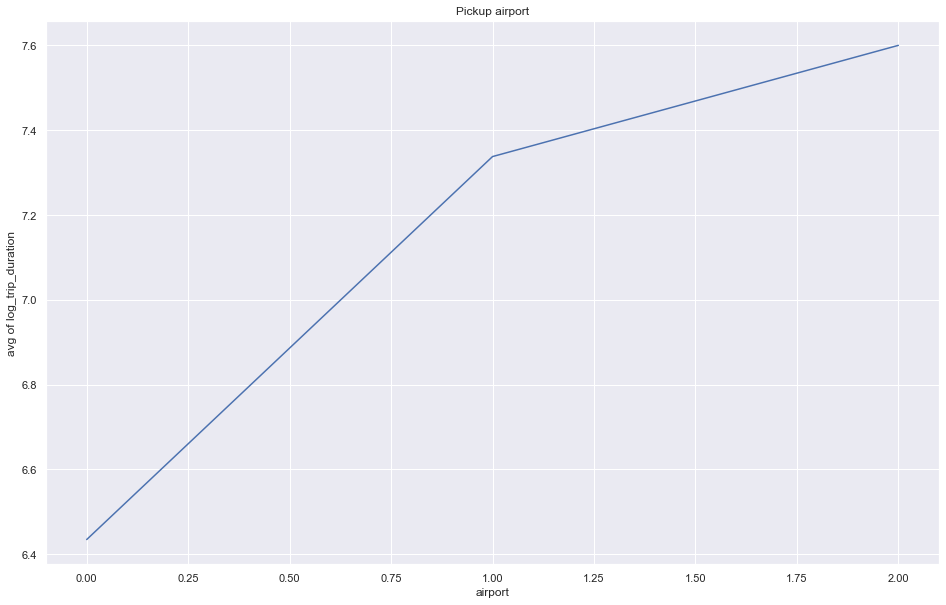

In [252]:
temp = train.groupby('pickup_airport').mean()['log_trip_duration']
plt.plot(temp.keys(), temp)
plt.xlabel('airport')
plt.ylabel('avg of log_trip_duration')
plt.title('Pickup airport')
plt.show()

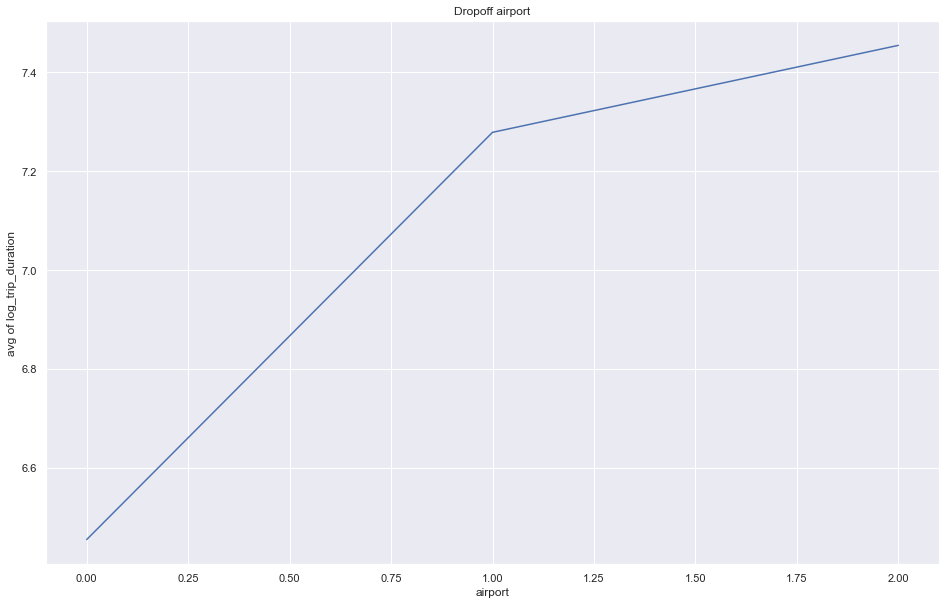

In [253]:
temp = train.groupby('dropoff_airport').mean()['log_trip_duration']
plt.plot(temp.keys(), temp)
plt.xlabel('airport')
plt.ylabel('avg of log_trip_duration')
plt.title('Dropoff airport')
plt.show()

## Преобразуем остальные признаки

In [254]:
train['vendor_id'] = train['vendor_id'] - 1

In [255]:
train['store_and_fwd_flag'] = (train['store_and_fwd_flag'] == 'Y').astype('int')

In [267]:
cat_c = ['vendor_id', 'store_and_fwd_flag', 'month', 'abnormal1', 'abnormal2', 'part_of_day', 'part_of_week', 'pickup_airport', 'dropoff_airport']

In [268]:
train = pd.get_dummies(train, columns=cat_c, drop_first=True)

## Выделим train и test

In [270]:
train, test = train_test_split(train, train_size=0.7)

In [312]:
train0, test0 = train, test

In [313]:
train, test = train0, test0 

## Избавимся от выбрасов

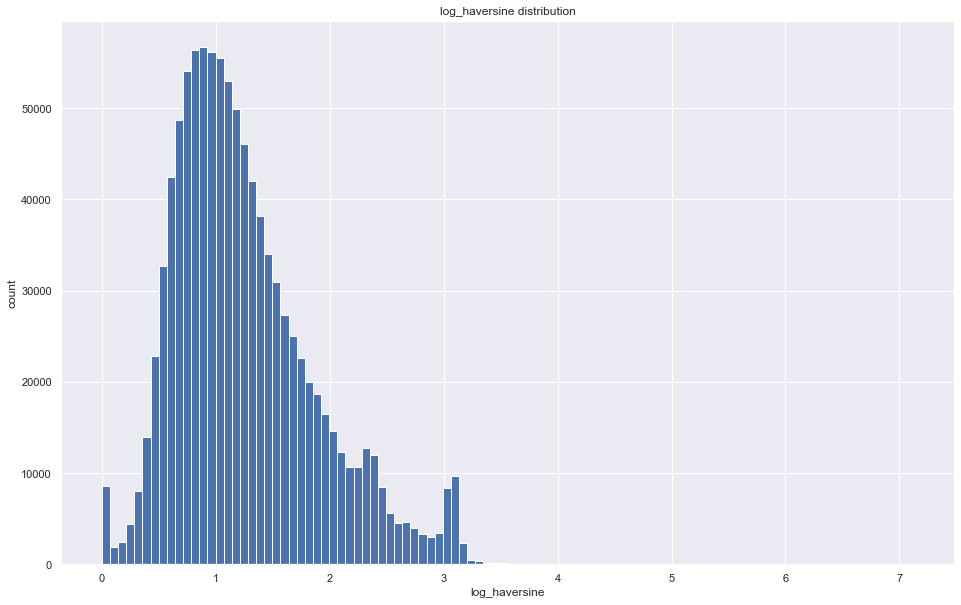

In [311]:
plt.hist(train['log_haversine'], bins=100)
plt.xlabel('log_haversine')
plt.ylabel('count')
plt.title('log_haversine distribution')
plt.show()

In [273]:
Q1 =  train['log_haversine'].quantile(0.25)
Q3 = train['log_haversine'].quantile(0.75)
IQR = Q3 - Q1
train = train[(train['log_haversine'] >= Q1-1.5*IQR ) & (train['log_haversine'] <= Q3+1.5*IQR)]

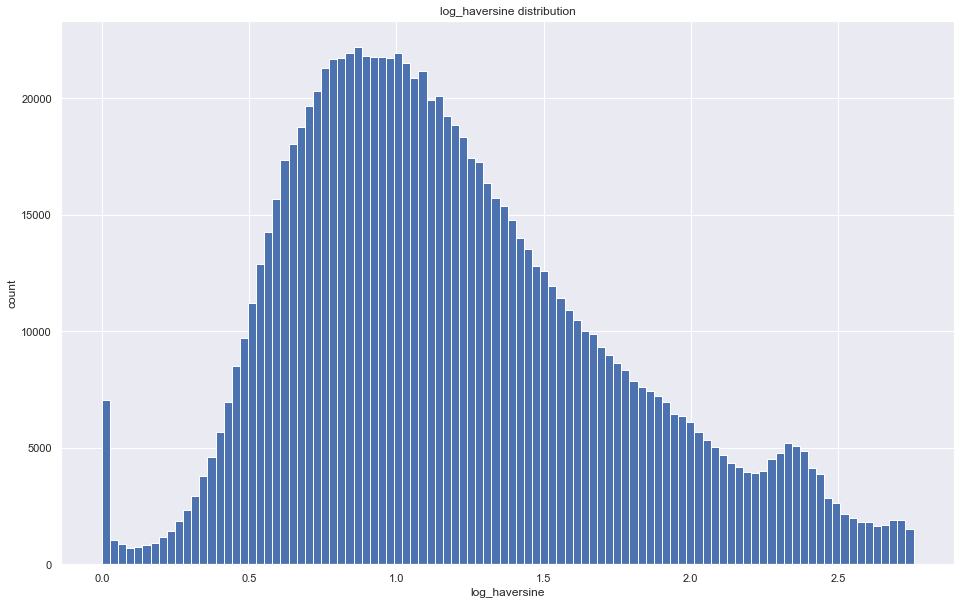

In [274]:
plt.hist(train['log_haversine'], bins=100)
plt.xlabel('log_haversine')
plt.ylabel('count')
plt.title('log_haversine distribution')
plt.show()

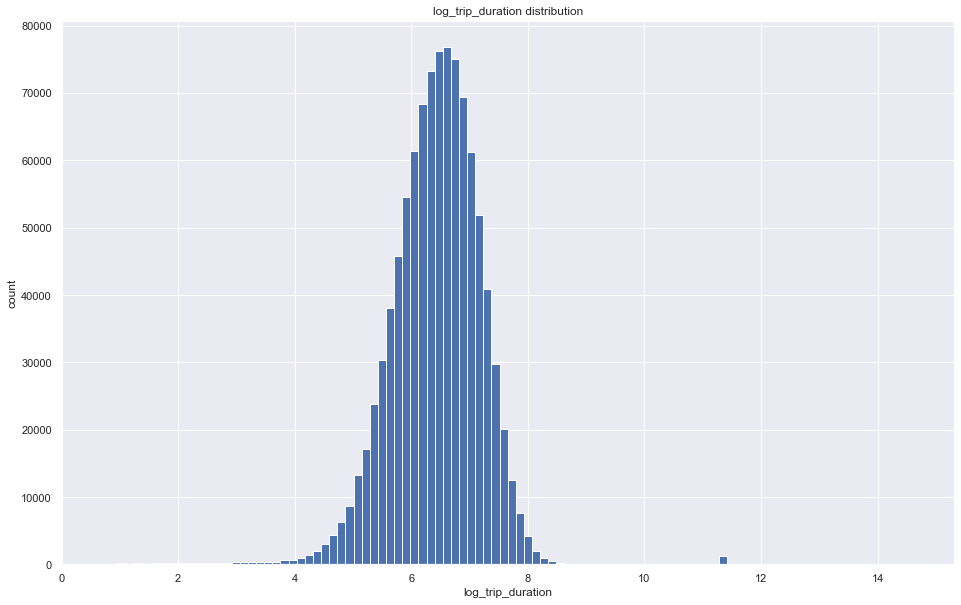

In [275]:
plt.hist(train['log_trip_duration'], bins=100)
plt.xlabel('log_trip_duration')
plt.ylabel('count')
plt.title('log_trip_duration distribution')
plt.show()

In [276]:
Q1 =  train['log_trip_duration'].quantile(0.25)
Q3 = train['log_trip_duration'].quantile(0.75)
IQR = Q3 - Q1
train = train[(train['log_trip_duration'] >= Q1-1.5*IQR ) & (train['log_trip_duration'] <= Q3+1.5*IQR)]

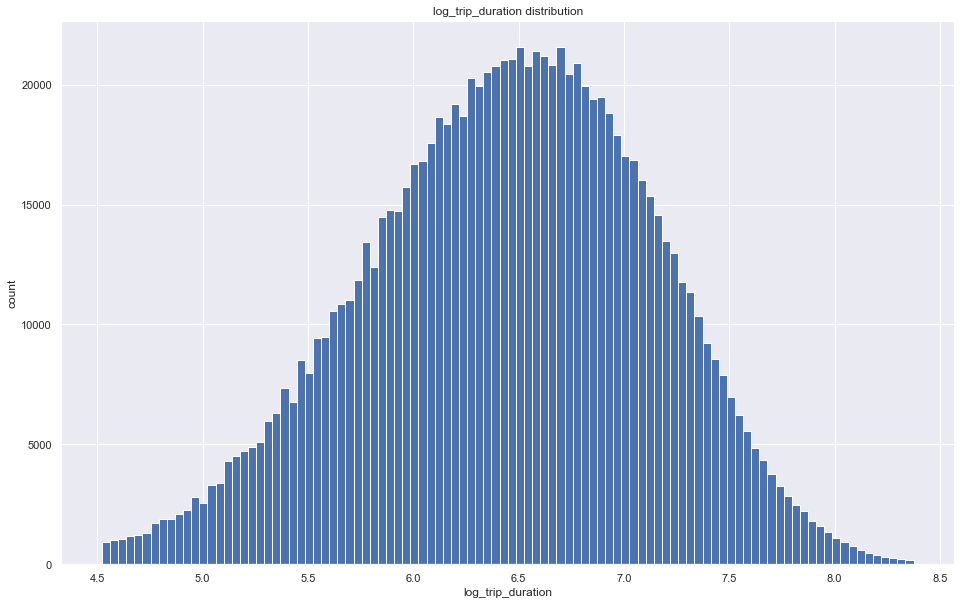

In [277]:
plt.hist(train['log_trip_duration'], bins=100)
plt.xlabel('log_trip_duration')
plt.ylabel('count')
plt.title('log_trip_duration distribution')
plt.show()

## Обучим линейные модели

In [314]:
X_tr, y_tr = train.drop('log_trip_duration', axis=1), train['log_trip_duration']
X_t, y_t = test.drop('log_trip_duration', axis=1), test['log_trip_duration']

In [315]:
num_c = ['day_of_year', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'haversine', 'log_haversine']

In [316]:
std_scaler = StandardScaler()
X_tr[num_c] = std_scaler.fit_transform(np.array(X_tr[num_c]))
X_t[num_c] = std_scaler.transform(np.array(X_t[num_c]))

In [317]:
ridge = Ridge()
lasso = Lasso()

In [318]:
ridge.fit(X_tr, y_tr)
lasso.fit(X_tr, y_tr)

Lasso()

In [319]:
mean_squared_error(y_t, ridge.predict(X_t), squared=False), mean_squared_error(y_tr, ridge.predict(X_tr), squared=False)

(0.5002536260818228, 0.4981113310732327)

In [320]:
mean_squared_error(y_t, lasso.predict(X_t), squared=False), mean_squared_error(y_tr, lasso.predict(X_tr), squared=False)

(0.7966818124302362, 0.7953635456820526)

In [326]:
alphas = np.logspace(0, 10, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_tr, y_tr)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid=[{'alpha': array([1.00000000e+00, 3.35981829e+00, 1.12883789e+01, 3.79269019e+01,
       1.27427499e+02, 4.28133240e+02, 1.43844989e+03, 4.83293024e+03,
       1.62377674e+04, 5.45559478e+04, 1.83298071e+05, 6.15848211e+05,
       2.06913808e+06, 6.95192796e+06, 2.33572147e+07, 7.84759970e+07,
       2.63665090e+08, 8.85866790e+08, 2.97635144e+09, 1.00000000e+10])}],
             scoring='neg_root_mean_squared_error')

In [327]:
best_alpha = searcher.best_params_["alpha"]
best_alpha

127.42749857031335

Text(0, 0.5, 'CV score')

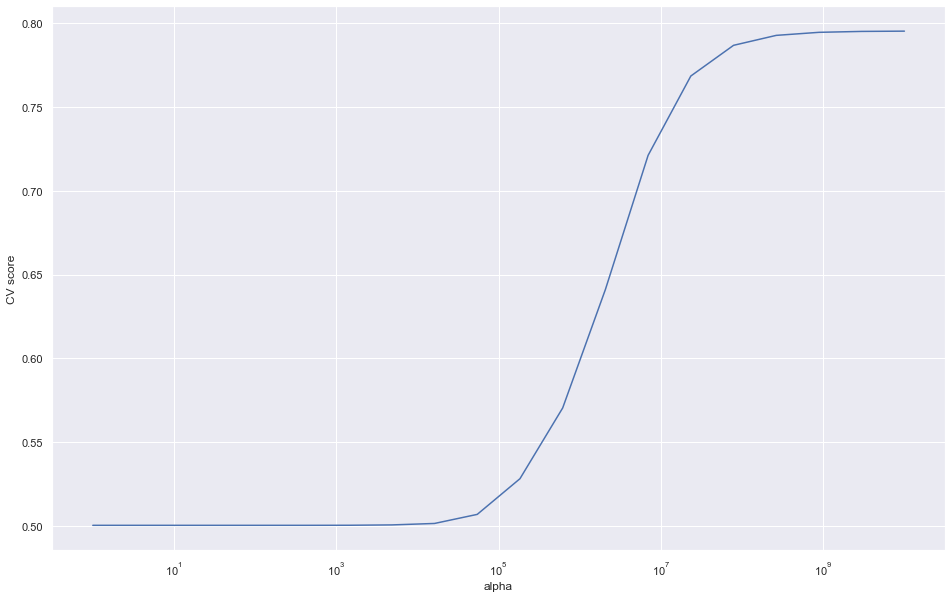

In [329]:
plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [330]:
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_tr, y_tr)

Ridge(alpha=127.42749857031335)

In [331]:
mean_squared_error(y_t, ridge.predict(X_t), squared=False), mean_squared_error(y_tr, ridge.predict(X_tr), squared=False)

(0.5002535165704971, 0.4981123652179975)

## Kaggle Submisson

In [336]:
test = pd.read_csv('test.csv')

In [337]:
i = test['id']

In [338]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])
test['day_of_week'] = test['pickup_datetime'].map(lambda x: x.day_of_week)
test['month'] = test['pickup_datetime'].map(lambda x: x.month)
test['hour'] = test['pickup_datetime'].map(lambda x: x.hour)
test['abnormal1'] = test['pickup_datetime'].map(abnormal1)
test['abnormal2'] = test['pickup_datetime'].map(abnormal2)
test['day_of_year'] = test['pickup_datetime'].map(lambda x: x.day_of_year)
test.drop('pickup_datetime', axis=1, inplace=True)      
test['haversine'] = haversine_array(test['pickup_latitude'], test['pickup_longitude'], test['dropoff_latitude'], test['dropoff_longitude'])
test['log_haversine'] = np.log1p(test['haversine'])
test['part_of_day'] = test['hour'].map(part_of_day)
test['part_of_week'] = test['day_of_week'].map(work_day)
test.drop(['day_of_week', 'hour'], axis=1, inplace=True)
test['pickup_airport'] = airport(test['pickup_latitude'], test['pickup_longitude'])
test['dropoff_airport'] = airport(test['dropoff_latitude'], test['dropoff_longitude'])
test['vendor_id'] = test['vendor_id'] - 1
test['store_and_fwd_flag'] = (test['store_and_fwd_flag'] == 'Y').astype('int')
test = pd.get_dummies(test, columns=cat_c, drop_first=True)

In [340]:
test.shape

(625134, 25)

In [343]:
test.drop('id', axis=1, inplace=True)

In [344]:
test

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,day_of_year,haversine,log_haversine,vendor_id_1,store_and_fwd_flag_1,...,month_6,abnormal1_1,abnormal2_1,part_of_day_1,part_of_day_2,part_of_week_1,pickup_airport_1,pickup_airport_2,dropoff_airport_1,dropoff_airport_2
0,1,-73.988129,40.732029,-73.990173,40.756680,182,2.746426,1.320802,0,0,...,1,0,0,0,0,1,0,0,0,0
1,1,-73.964203,40.679993,-73.959808,40.655403,182,2.759239,1.324217,0,0,...,1,0,0,0,0,1,0,0,0,0
2,1,-73.997437,40.737583,-73.986160,40.729523,182,1.306155,0.835582,0,0,...,1,0,0,0,0,1,0,0,0,0
3,1,-73.956070,40.771900,-73.986427,40.730469,182,5.269088,1.835631,1,0,...,1,0,0,0,0,1,0,0,0,0
4,1,-73.970215,40.761475,-73.961510,40.755890,182,0.960842,0.673374,0,0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625129,1,-74.003464,40.725105,-74.001251,40.733643,1,0.967438,0.676732,0,0,...,0,0,0,0,0,1,0,0,0,0
625130,1,-74.006363,40.743782,-73.953407,40.782467,1,6.196343,1.973573,0,0,...,0,0,0,0,0,1,0,0,0,0
625131,2,-73.972267,40.759865,-73.876602,40.748665,1,8.153719,2.214160,0,0,...,0,0,0,0,0,1,0,0,0,0
625132,1,-73.976501,40.733562,-73.854263,40.891788,1,20.380748,3.062491,0,0,...,0,0,0,0,0,1,0,0,0,0


In [345]:
test[num_c] = std_scaler.transform(test[num_c])

In [361]:
a = pd.DataFrame({'trip_duration': np.exp(ridge.predict(test))-1}, index=i)

In [362]:
a.to_csv("prediction.csv")